# Model 1 (D+3)

Alexandre

Here is a research notebook used for tests, here we do not try to have a good accuracy but rather the shape of what our script should look like.

### Import librairies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime
from keras.utils import to_categorical

Using TensorFlow backend.


Install the jupyter-tensorboard extension if needed:

https://github.com/lspvic/jupyter_tensorboard

In [2]:
#%pip install jupyter-tensorboard

Load Tensorboard:

In [3]:
%load_ext tensorboard

### Parameters:

In [4]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/completeDataset/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

### Import dataset and categorize the wind_direction:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

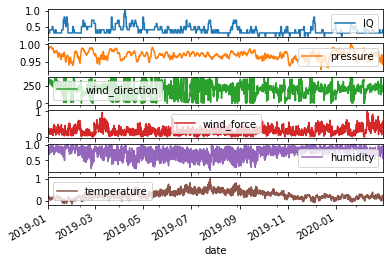

,IQ,pressure,wind_force,humidity,temperature,0,10,20,30,40,...,270,280,290,300,310,320,330,340,350,360
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,0.3,0.986479,0.152632,0.89,0.173913,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 03:00:00+00:00,0.3,0.985807,0.152632,0.85,0.173913,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2019-01-01 06:00:00+00:00,0.3,0.985040,0.152632,0.84,0.171498,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 09:00:00+00:00,0.3,0.985136,0.189474,0.84,0.178744,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 12:00:00+00:00,0.3,0.984273,0.300000,0.85,0.207729,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')
df['date'] = pd.to_datetime(df['date'],utc=True)

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(features,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['IQ'] = features['IQ'].apply(lambda x: x/10)
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

features.plot(subplots=True)
plt.show()

#wind_direction to categorical
features = pd.concat([features, pd.get_dummies(features['wind_direction'])], axis=1)
features = features.drop(columns=["wind_direction"])

features.head()

### Create training data

#### Set the parameters:

In [6]:
#Params
nb_prev_measures_for_predict = 16 # = N in the following explanation

#### Create the x_train: 
For each day we want to make a prediction of the air quality based on the N previous observation, sarting from the one at 12:00 of this day.

In [7]:
x_train = []
y_train = []
countRow=0

for indexRow, rowx in features.iterrows():
    # for each day we found with a value at 12:00
    if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
        try:
            # indexes for x (the range is inversed as our data are from the oldest to the newest)
            batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
            # indexes for y
            batchY = [countRow,countRow+8,countRow+16]

            #application
            y_train.append(features.iloc[batchY]["IQ"].values)
            x_train.append(features.iloc[batchX].values)
        except:
            print("To long for ",indexRow),
    countRow+=1
    
x_train = np.array(x_train)
y_train = np.array(y_train)
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

To long for  2020-02-28 12:00:00+00:00
To long for  2020-02-29 12:00:00+00:00
x_train : (421, 16, 42)
y_train : (421, 3)


____________________________________

### Load the model or create it:

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [9]:
OPTIMIZER = tf.train.RMSPropOptimizer(learning_rate=0.005)
LOSS = 'mae'

if LOAD_MODEL: 
    model = keras.models.load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])

    model = Sequential()
    model.add(LSTM(512,input_shape=input_shape,name='LSTM_layer'))
    model.add(Dense(3,name="Dense_layer"))
    model.compile(optimizer=OPTIMIZER, loss=LOSS)
    model.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_layer (LSTM)            (None, 512)               1136640   
_________________________________________________________________
Dense_layer (Dense)          (None, 3)                 1539      
Total params: 1,138,179
Trainable params: 1,138,179
Non-trainable params: 0
_________________________________________________________________


### Train

In [10]:
EPOCHS = 20
kfoldsize = 5

tensor_board = tf.keras.callbacks.TensorBoard('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    model.fit(x=x, y=y, validation_data=(x_val,y_val),epochs=EPOCHS,callbacks = [tensor_board])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Train on 336 samples, validate on 85 samples
Epoch 1/20
336/336 [==============================] - 7s 19ms/step - loss: 0.3178 - val_loss: 0.2377
Epoch 2/20
336/336 [==============================] - 3s 9ms/step - loss: 0.1347 - val_loss: 0.1227
Epoch 3/20
336/336 [==============================] - 2s 7ms/step - loss: 0.0933 - val_loss: 0.1210
Epoch 4/20
336/336 [==============================] - 3s 10ms/step - loss: 0.0909 - val_loss: 0.1202
Epoch 5/20
336/336 [==============================] - 2s 6ms/step - loss: 0.0898 - val_loss: 0.1107
Epoch 6/20
336/336 [==============================] - 2s 7ms/step - loss: 0.1224 - val_loss: 0.1305
Epoch 7/20
336/336 [==============================] - 3s 9ms/step - loss: 0.1265 - val_loss: 0.1304
Epoch 8/20
336/336 [===================

337/337 [==============================] - 1s 3ms/step - loss: 0.0441 - val_loss: 0.0532
Epoch 11/20
337/337 [==============================] - 1s 3ms/step - loss: 0.0439 - val_loss: 0.0475
Epoch 12/20
337/337 [==============================] - 1s 3ms/step - loss: 0.0385 - val_loss: 0.0630
Epoch 13/20
337/337 [==============================] - 2s 5ms/step - loss: 0.0445 - val_loss: 0.0506
Epoch 14/20
337/337 [==============================] - 1s 4ms/step - loss: 0.0392 - val_loss: 0.0512
Epoch 15/20
337/337 [==============================] - 2s 5ms/step - loss: 0.0409 - val_loss: 0.0565
Epoch 16/20
337/337 [==============================] - 1s 4ms/step - loss: 0.0385 - val_loss: 0.0560
Epoch 17/20
337/337 [==============================] - 2s 4ms/step - loss: 0.0388 - val_loss: 0.0529
Epoch 18/20
337/337 [==============================] - 1s 4ms/step - loss: 0.0394 - val_loss: 0.0542
Epoch 19/20
337/337 [==============================] - 2s 5ms/step - loss: 0.0379 - val_loss: 0.0520
Ep

### See the training in tensorboard

In [11]:
#%tensorboard --logdir=./logs

### See the results

In [12]:
def calc_accuracy_3days(y_pred,y_true):
    """
    calculate the accurracy of the prediction according to the true value for each day [D+1, D+2, D+3]
    """
    accuracy = [0,0,0]
    for pred,true in zip (y_pred,y_true):
        for plusDay in range(3):
            if true[plusDay] == round(pred[plusDay]):
                accuracy[plusDay]+=1
    return(np.array(accuracy)/len(y_true)*100)
    
def mean_error_3days(y_pred,y_true):
    """
    calculate the mean error between the prediction and the true value for each day [D+1, D+2, D+3]
    """
    error = [0,0,0]
    for pred,true in zip (y_pred,y_true):
        for plusDay in range(3):
            error[plusDay] += abs(true[plusDay] - pred[plusDay])
    return(np.array(error)/len(y_true))

Calculate the accuracy and mean error for each day [D+1, D+2, D+3]:

In [13]:
y_pred = model.predict(x_train)
accuracy = calc_accuracy_3days(y_pred,y_train)
meanError = mean_error_3days(y_pred,y_train)

Show the results in graphs:

Prediction of the air index quality (on training data)


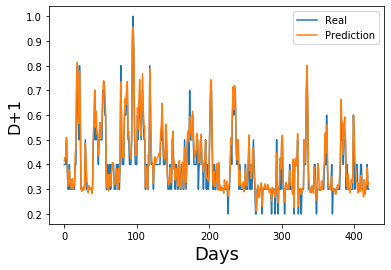

Accuracy with training data: 0.24 %
Mean error with training data: 0.03


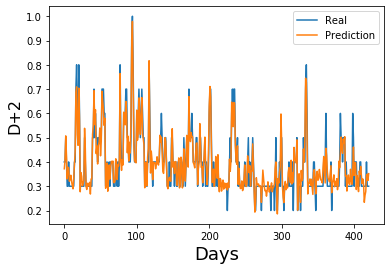

Accuracy with training data: 0.24 %
Mean error with training data: 0.03


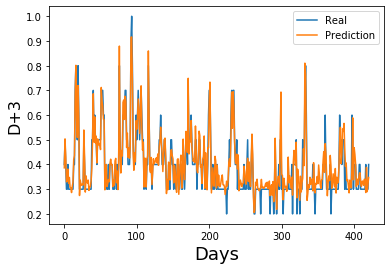

Accuracy with training data: 0.24 %
Mean error with training data: 0.03


In [14]:
print('Prediction of the air index quality (on training data)')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train[:,plusDay], label='Real')
    plt.plot(y_pred[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()

    print("Accuracy with training data:",round(accuracy[plusDay],2),"%")
    print("Mean error with training data:",round(meanError[plusDay],2))
